## 预处理

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 导入数据集
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv").sort_values(["store_nbr", "date"])

# 将日期列转换为datetime类型
transactions['date'] = pd.to_datetime(transactions['date'])
train['date'] = pd.to_datetime(train['date'])

# 转换数据类型以提高效率
train['onpromotion'] = train['onpromotion'].astype("float16")
train['sales'] = train['sales'].astype("float32")
stores['cluster'] = stores['cluster'].astype("int8")

# 聚合月度交易数据
monthly_transactions = transactions.groupby(['store_nbr', pd.Grouper(key='date', freq='ME')]).transactions.sum().reset_index()

# 将商店信息与月度交易数据合并
monthly_data = pd.merge(monthly_transactions, stores, on='store_nbr', how='left')

# 添加时间特征
monthly_data['year'] = monthly_data['date'].dt.year
monthly_data['month'] = monthly_data['date'].dt.month

# 转换数据类型，以便内存效率更高和模型准备
monthly_data['transactions'] = monthly_data['transactions'].astype("float32")
monthly_data['cluster'] = monthly_data['cluster'].astype("int8")

# 对商店的分类特征进行独热编码
categorical_features = ['city', 'state', 'type', 'cluster']
monthly_data_encoded = pd.get_dummies(monthly_data, columns=categorical_features)

# 使用自定义日期分割数据集为训练集和验证集
cutoff_date = pd.to_datetime('2017-01-01')  
train_set = monthly_data_encoded[monthly_data_encoded['date'] < cutoff_date]
validation_set = monthly_data_encoded[monthly_data_encoded['date'] >= cutoff_date]

# 为模型准备训练集和验证集
X_train = train_set.drop(columns=['transactions', 'date'])
y_train = train_set['transactions']
X_validation = validation_set.drop(columns=['transactions', 'date'])
y_validation = validation_set['transactions']


X = monthly_data_encoded.drop(columns=['transactions', 'date'])
y = monthly_data_encoded['transactions']


### 统计分析

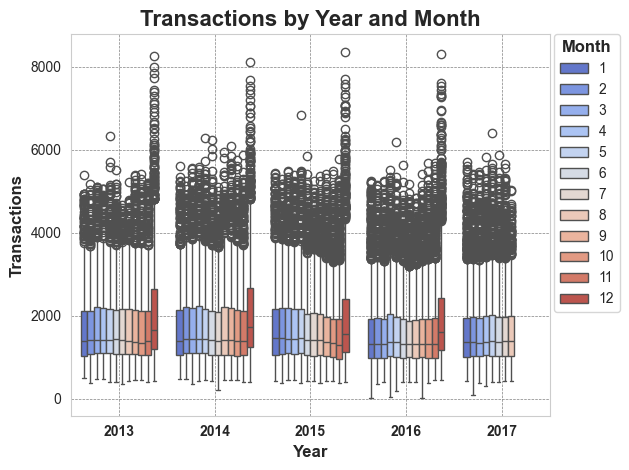

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

a = transactions.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
a["year_month"] = a["year"].astype(str) + "-" + a["month"].astype(str).str.zfill(2)

# Sorting the data by year and month for better visualization
a_sorted = a.sort_values(["year", "month"])

palette = sns.color_palette("coolwarm", 12)

# 创建箱型图
sns.boxplot(data=a_sorted, x='year', y='transactions', hue='month', palette=palette)

# 设置图表标题和坐标轴标签
plt.title('Transactions by Year and Month', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Transactions', fontsize=12, fontweight='bold')

# 设置图例
leg = plt.legend(title='Month', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.setp(leg.get_title(), fontsize=12, fontweight='bold')
plt.setp(leg.texts, fontsize=10) 

# 调整网格线样式
sns.set_style("whitegrid", {'axes.grid' : True})
plt.grid(linestyle='--', linewidth=0.5, color='gray')

# 调整坐标轴刻度样式
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10)

# 调整布局
plt.tight_layout()

# 展示图表
plt.show()


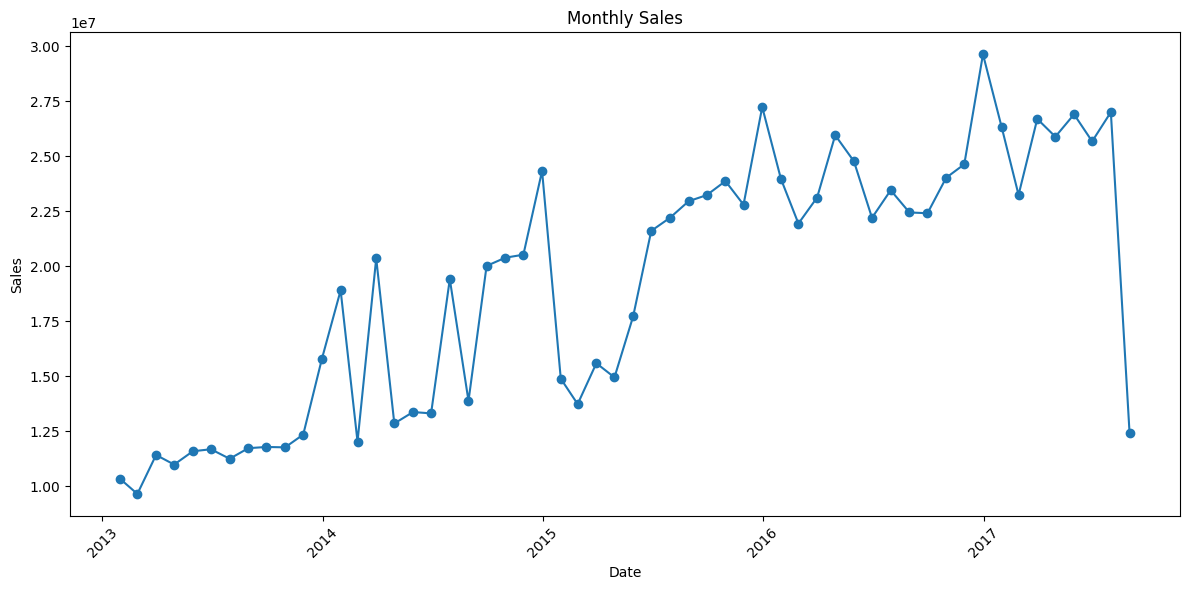

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 按月份对销售额进行汇总
monthly_sales = train.resample('ME', on='date').sales.sum().reset_index()

# 使用Matplotlib绘制图表
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['date'], monthly_sales['sales'], marker='o', linestyle='-')
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


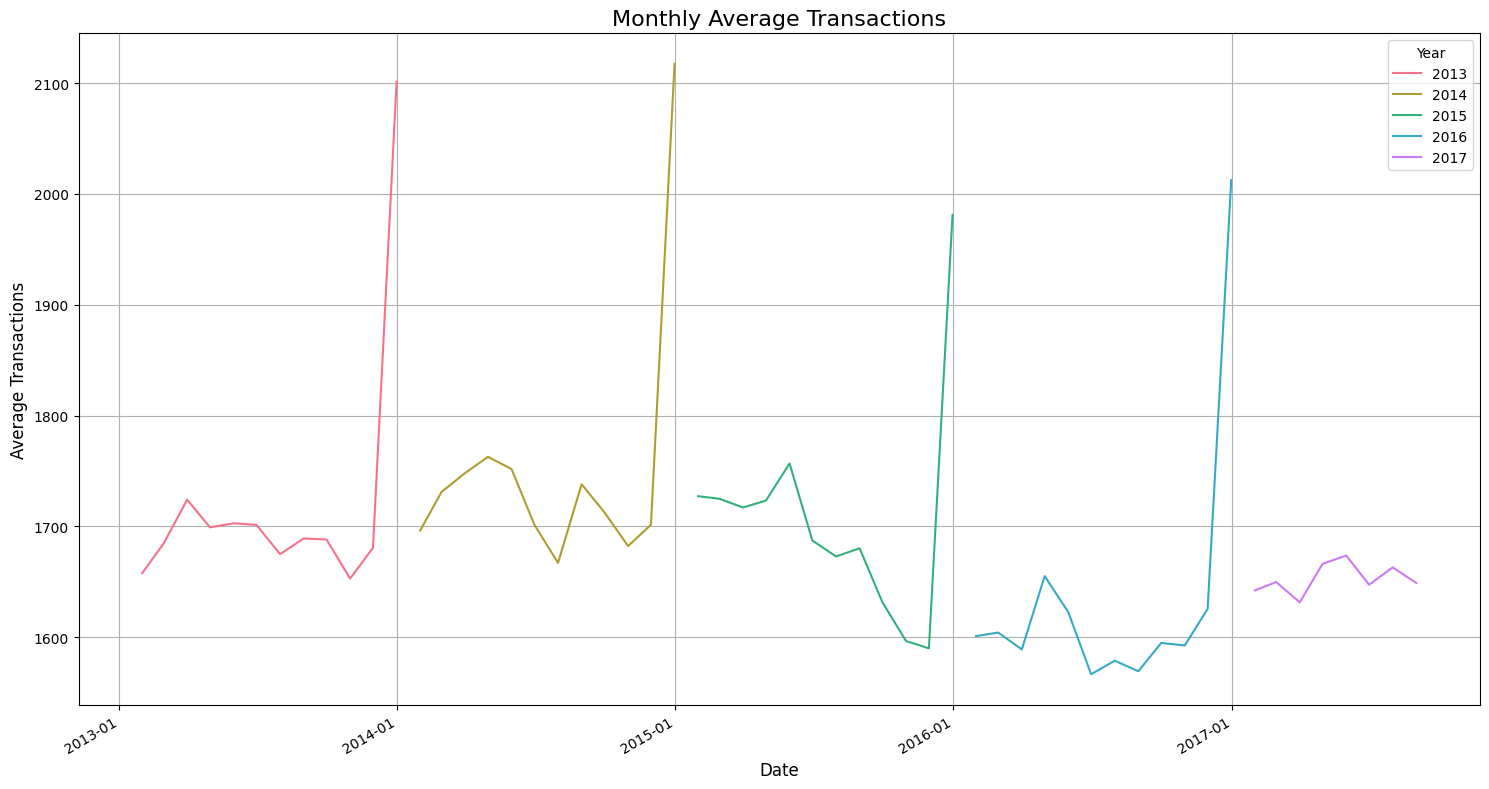

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Resample to get the monthly average of transactions
a = transactions.set_index("date").resample("ME").transactions.mean().reset_index()

# Extract the year for later grouping
a["year"] = a.date.dt.year

# Set the figure size
plt.figure(figsize=(15, 8))

# Using seaborn's color palette for years
palette = sns.color_palette("husl", len(a['year'].unique()))

# Group by year and plot
for i, (year, group) in enumerate(a.groupby('year')):
    plt.plot(group['date'], group['transactions'], label=year, color=palette[i])

# Set the title and labels
plt.title('Monthly Average Transactions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Transactions', fontsize=12)

# Improve formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format x-ticks as Year-Month
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Locate x-ticks at the start of each year
plt.gcf().autofmt_xdate()  # Rotate date labels for better spacing
plt.legend(title='Year')  # Add legend with title

# Show grid
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


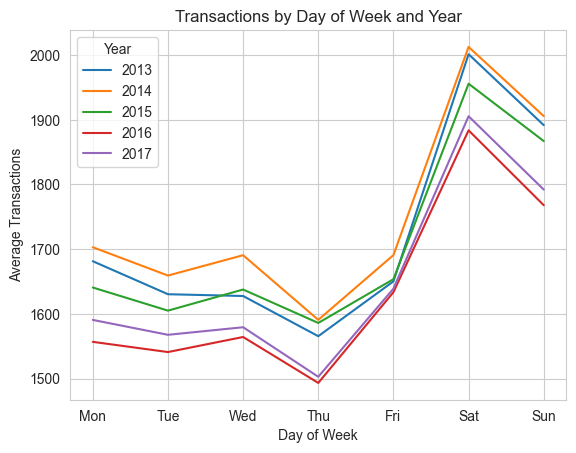

In [101]:
import matplotlib.pyplot as plt
import pandas as pd


a = transactions.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek + 1  # 将星期天从0变为1，星期六为7
a = a.groupby(["year", "dayofweek"])["transactions"].mean().reset_index()

# 使用Matplotlib绘制线图
fig, ax = plt.subplots()

# 对于数据中的每一个年份，绘制一条线
for year in a["year"].unique():
    df_year = a[a["year"] == year]
    ax.plot(df_year["dayofweek"], df_year["transactions"], label=str(year))

ax.set_xlabel("Day of Week")
ax.set_ylabel("Average Transactions")
ax.set_title("Transactions by Day of Week and Year")
ax.legend(title="Year")

plt.xticks(ticks=range(1, 8), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # 设置x轴的刻度标签为星期几
plt.show()


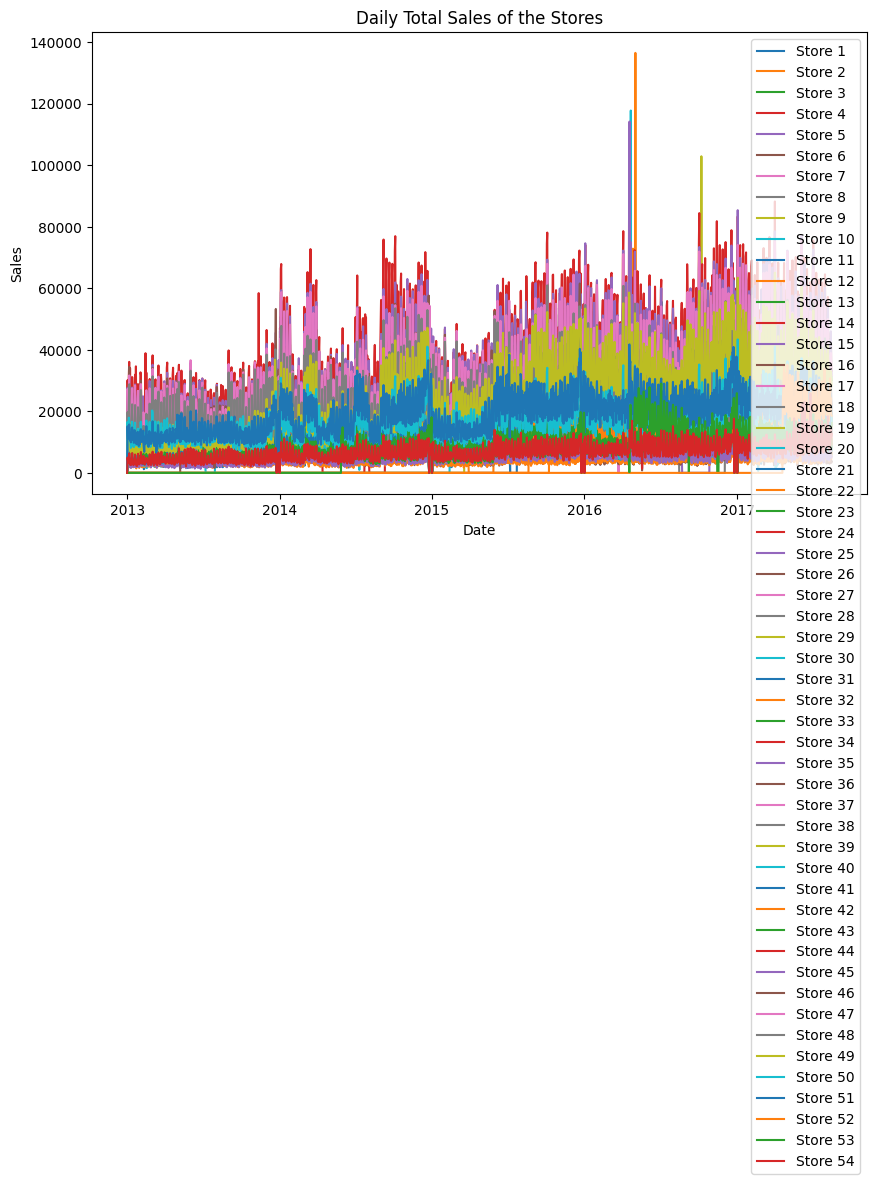

In [4]:
import matplotlib.pyplot as plt
df = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()

# 设置图形大小
plt.figure(figsize=(10, 6))

# 通过循环，为每个商店绘制数据
for store in df['store_nbr'].unique():
    store_data = df[df['store_nbr'] == store]
    plt.plot(store_data['date'], store_data['sales'], label=f'Store {store}')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title("Daily Total Sales of the Stores")
plt.xlabel("Date")
plt.ylabel("Sales")

# 显示图形
plt.show()



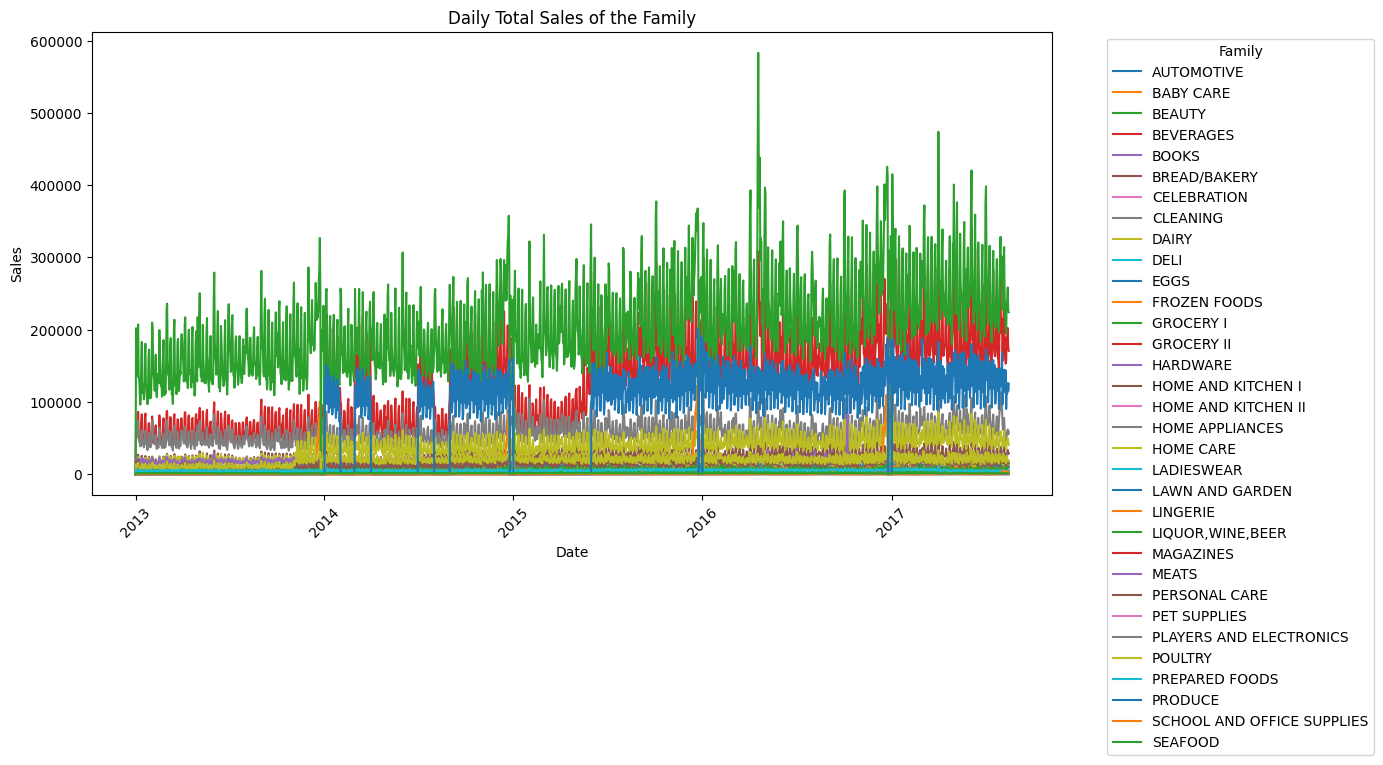

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

df = train.set_index("date").groupby("family").resample("D").sales.sum().reset_index()

# Pivot the data to get 'family' in the columns and dates as the index
df_pivot = df.pivot(index='date', columns='family', values='sales')

# Plotting the data using matplotlib
plt.figure(figsize=(14, 7))  # You can adjust the size as needed

# Plot each family's sales over time
for family in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[family], label=family)

# Add title and labels
plt.title('Daily Total Sales of the Family')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add legend
plt.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis date labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust the layout to fit everything
plt.show()


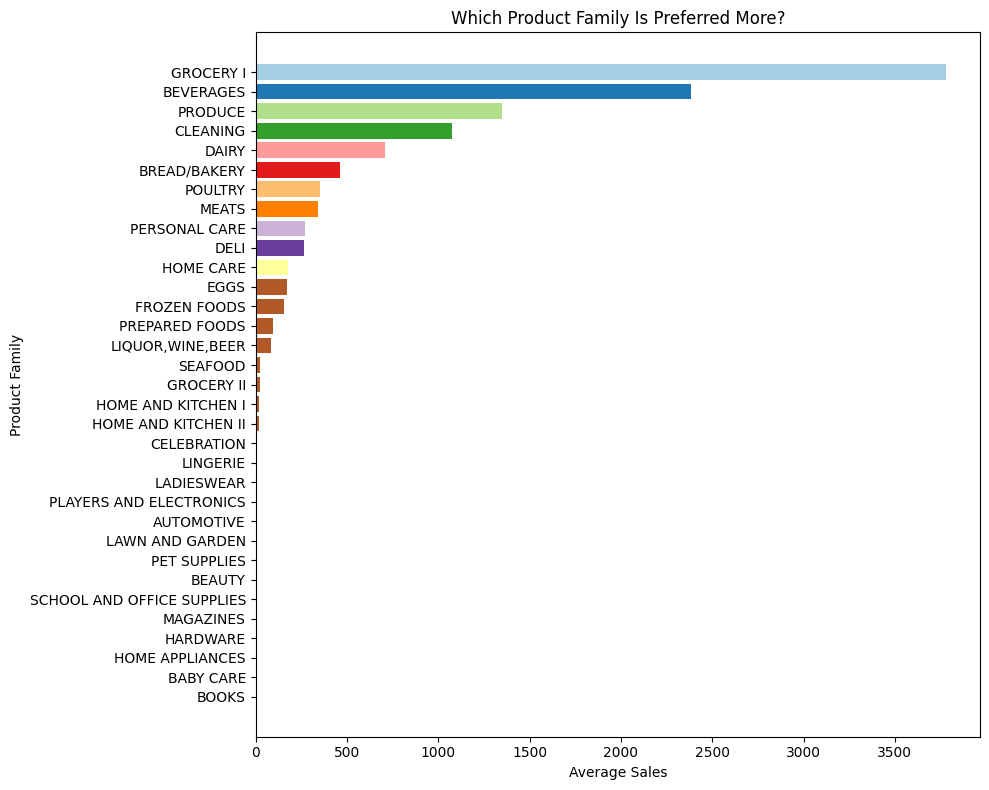

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# First, group by 'family' and calculate the mean sales, then sort in descending order
df = train.groupby("family").sales.mean().sort_values(ascending=False).reset_index()

# Now, let's create a horizontal bar chart using matplotlib
plt.figure(figsize=(10, 8))  # Set the figure size as desired
plt.barh(df['family'], df['sales'], color=plt.cm.Paired(range(len(df))))  # Use a colormap for the bars

# Adding the title to the plot
plt.title("Which Product Family Is Preferred More?")

# Adding labels to the axes
plt.xlabel("Average Sales")
plt.ylabel("Product Family")

# Inverting the y-axis to show the largest bar on top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()  # Adjust the padding of the plot
plt.show()


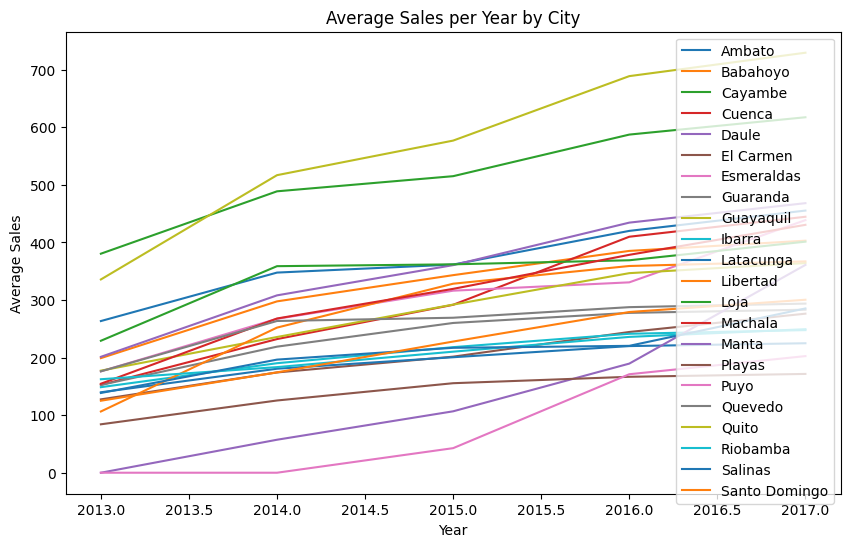

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.merge(train, stores)
df["store_nbr"] = df["store_nbr"].astype("int8")
df["year"] = df.date.dt.year

# 按照城市和年份分组，计算平均销售额
grouped_df = df.groupby(["city", "year"]).sales.mean().reset_index()

# 开始绘制
plt.figure(figsize=(10, 6))  # 设置图形大小

# 获取城市列表
cities = grouped_df['city'].unique()

# 对每个城市进行循环，绘制每年的平均销售额
for city in cities:
    city_data = grouped_df[grouped_df['city'] == city]
    plt.plot(city_data['year'], city_data['sales'], label=city)

# 添加图例
plt.legend()

# 添加图表标题和轴标签
plt.title('Average Sales per Year by City')
plt.xlabel('Year')
plt.ylabel('Average Sales')

# 显示图表
plt.show()


## 线性回归预测

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 训练线性回归
model = LinearRegression()
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_validation)

# 评估
mse = mean_squared_error(y_validation, y_pred)
print(f'Validation MSE: {mse}')

Validation MSE: 221503469.4267655


In [14]:
model_full = LinearRegression()


model_full.fit(X, y)
future_data_example = pd.DataFrame({
    'year': [2017],
    'month': [9],
     'store_nbr': [1],
})

# 填充缺失的独热编码列为0
for column in X.columns:
    if column not in future_data_example.columns:
        future_data_example[column] = 0

# 确保列的顺序与训练数据相同
future_data_example = future_data_example[X.columns]
future_predictions = model_full.predict(future_data_example)
print(f"预测的未来交易量: {future_predictions[0]}")


预测的未来交易量: 76905.82318455563


In [15]:
import pandas as pd


# 确保'date'列是datetime类型
transactions['date'] = pd.to_datetime(transactions['date'])

# 筛选特定商店和时间范围的数据
filtered_transactions = transactions[(transactions['store_nbr'] == 1) & (transactions['date'].dt.year == 2017) & (transactions['date'].dt.month == 6)]

# 聚合筛选后的数据以计算总交易量
total_transactions = filtered_transactions['transactions'].sum()

print(f"Store number 1 had {total_transactions} transactions in June 2017.")


Store number 1 had 47479 transactions in June 2017.
